In [1]:
import numpy as np
import pandas as pd
from math import sqrt, log
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

In [2]:
def get_weights(cov, m1, m2):
    W = np.dot(np.linalg.inv(cov), (m1-m2).T)
    return W

In [3]:
def get_covariance_matrix(X, Y=None):
    if Y is None:
        m = np.mean(X, axis=0)
        temp = np.dot((X-m).T, (X-m))
        return (temp / X.shape[0])
    else:
        cov = get_covariance_matrix(X) + get_covariance_matrix(Y)
        return cov  

In [4]:
def get_gaussian_dist(X):
    m = np.mean(X)
    v = np.var(X)
    Z = -((X-m)**2)/(2*v)
    Y = (1/sqrt(2*np.pi*v)) * np.exp(Z)
    return Y

In [5]:
def quadratic_solver(a, b, c):
    delta = ((b**2) - 4*a*c)
    r1 = (-b + sqrt(delta))/(2*a)
    r2 = (-b - sqrt(delta))/(2*a)
    return (r1, r2)

In [6]:
def gaussian_intersection_point(X1, X2):
    m1 = np.mean(X1)
    v1 = np.var(X1)
    m2 = np.mean(X2)
    v2 = np.var(X2)
    
    a = (1/v2 - 1/v1)
    b = 2*(m1/v1 - m2/v2)
    c = (((m2**2)/v2 - (m1**2)/v1) + log(v2/v1))
    return quadratic_solver(a, b, c)

In [7]:
def evaluate(pt, W, X):
    cm = np.array([[0, 0], [0, 0]])
    l = X.shape[1]
    for row in X:
        x = np.dot(row[:l-1], W.T)
        y = int(row[-1])
        y_hat = (0 if x <= pt else 1)
        cm[y_hat][y] += 1

    accuracy = ((cm[0][0] + cm[1][1]) / np.sum(cm)) * 100
    recall = (cm[1][1] / (cm[1][1] + cm[0][1])) * 100
    precision = (cm[1][1] / np.sum(cm[1])) * 100
    fscore = 2 * ((precision * recall) / (precision + recall))
    print(f"accuracy: {accuracy}\nfscore: {fscore}")

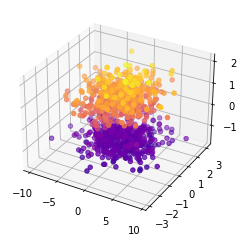

In [8]:
data = "dataset_FLD.csv"
ax = plt.axes(projection="3d")
df = pd.read_csv(data, names=["F0", "F1", "F2", "T"], sep=",")
X, Y, Z = df["F0"][1:], df["F1"][1:], df["F2"][1:]
ax.scatter3D(X, Y, Z, c=Z, cmap="plasma")
plt.show()

In [9]:
df_pos, df_neg = [x for _, x in df.groupby(df["T"] == 0)]
pos_classes = np.array(df_pos.drop("T", 1))
neg_classes = np.array(df_neg.drop("T", 1))


W = get_weights(cov=get_covariance_matrix(pos_classes, neg_classes), 
                m1=np.mean(pos_classes, axis=0),
                m2=np.mean(neg_classes, axis=0))

W_hat = W/np.linalg.norm(W)
reduced_pc = np.sort(np.dot(pos_classes, W.T))
reduced_nc = np.sort(np.dot(neg_classes, W.T))
P, Q = gaussian_intersection_point(reduced_pc, reduced_nc)
print(W_hat)

[-0.00655686 -0.01823739  0.99981218]
-4.406931564733935


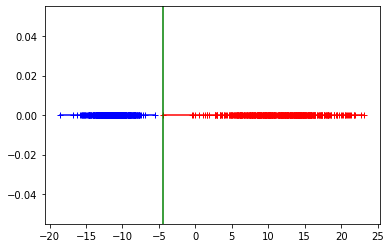

In [10]:
fig, ax = plt.subplots()
loc = plticker.MultipleLocator(base=5.0)
ax.plot(reduced_pc, np.zeros(len(reduced_pc)), color="red", marker="+")
ax.plot(reduced_nc, np.zeros(len(reduced_nc)), color="blue", marker="+")
ax.axvline(x=P, color="green")
ax.xaxis.set_major_locator(loc)
plt.show()

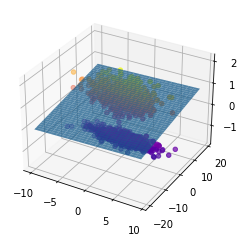

In [11]:
ax = plt.axes(projection="3d")
xx, yy = np.meshgrid(range(-10, 10), range(-20, 20))
zz = ((-W[0]*xx - W[1]*yy - P) * (1/W[2]))
ax.plot_surface(xx, yy, zz, alpha=0.75)
ax.scatter3D(X, Y, Z, c=Z, cmap="plasma")
plt.show()

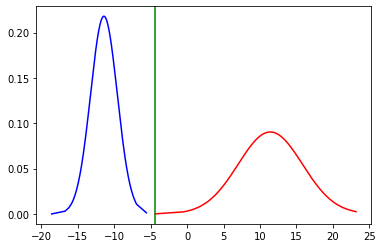

In [12]:
fig, ax = plt.subplots()
Yp = get_gaussian_dist(reduced_pc)
Yn = get_gaussian_dist(reduced_nc)
ax.plot(reduced_pc, Yp, color="red")
ax.plot(reduced_nc, Yn, color="blue")
ax.axvline(x=P, color="green")
ax.xaxis.set_major_locator(loc)
plt.show()

In [13]:
evaluate(P, W, np.array(df))

accuracy: 100.0
fscore: 100.0
